In [1]:
from html_cleaner import html_cleaner #import function that cleans up html and returns unique words from the text
from bs4 import BeautifulSoup #for HTML parsing
from urllib.request import urlopen #website connections
from urllib.parse import urljoin # to connect disparate sections of URLs
from nltk.corpus import stopwords #to filter out stopwords like 'the', 'or', etc.
import re #regular expressions
from time import sleep, time #prevent overwhelming the server; clock how long code is taking
from collections import Counter # keep track of term counts
import pandas as pd #for data frames
import numpy as np
from tqdm import tqdm #to show progress of scraping
from joblib import Parallel, delayed # to parallelize/speed up accessing and scraping websites
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns #for plotting counts/percentages of job postings
%matplotlib inline

In [2]:
def ask_city():
    """
    function prompts user to enter a city
    Checks for invalid input like integers
    in order to have a faster return, user must enter a city and state
    blank would result in a long, nationwide search
    """
    while True:
        try:
            print("Enter a city name to search that location for jobs.")
            city_search = str(input())
            
            if not re.match("^[a-zA-Z]*$", city_search):
                print("Only letters a-z allowed.")
            
            elif len(city_search) == 0:
                print("Please enter a city.")
            
            else:
                city_search = city_search.split()
                city_search = '+'.join(word for word in city_search)
                return city_search
        
        except ValueError:
            print("That's not a string. Please enter a city name.")

def ask_state():
    """
    function prompts user to enter a state's two letter abbreviation
    Checks for invalid input like integers
    """
    while True:
        try:
            print("Enter a state location (2 letter abbreviation) to search that location for jobs.")
            state_search = str(input())
            
            if not re.match("^[a-zA-Z]*$", state_search):
                print("Only letters a-z allowed.")
            
            elif len(state_search) == 2:
                return state_search
            
            else:
                print("Please enter the state's two letter abbreviation")
                
        except ValueError:
            print("That's not a string. Please enter a two letter abbreviation.")

def ask_job():
    """
    function prompts user to enter job title or keyword (2 words max)
    return the term that will show up in the URL
    """
    while True:
        try:
            print("Enter a job title, keyword, or company name to search.")
            # print("For example, 'data scientist'")
            job_search = str(input())
            
            if len(job_search.split()) > 2:
                print("Please limit your search to two words maximum to optimize search results")
            
            elif len(job_search) == 0:
                print("Please enter a search term")
            
            else:
                job_search = job_search.split()
                job_search = '+'.join(word for word in job_search)
                return job_search
        
        except ValueError:
            print("That's not a string. Please enter a search term")

In [3]:
def get_url():
    """
    This function returns the indeed URL produced when you search for job term + city + state
    """
    #ask for input of city, state, job
    city_loc = ask_city()
    state_loc = ask_state()
    job_term = ask_job()
    
    # join elements together to form URL

    final_search = ['http://www.indeed.com/jobs?q=', job_term, '&l=', city_loc, '%2C', state_loc]
    final_url = ''.join(final_search) 
    
    return final_url

In [4]:
def get_num_jobs(url):
    """
    This function takes the url and returns the number of jobs that the Indeed search returns
    """
    r = urlopen(url).read() #open URL
    soup = BeautifulSoup(r, "html.parser") #get the html from the first page of search results

    # look within results to find where number of jobs are shown
    # <div id="searchCount">Jobs 1 to 10 of 126,936</div>
    
    num_jobs = soup.find(id = 'searchCount').string.encode('utf-8')
    
    #this returns a list of 3 numbers; we want the third number (total number of jobs)
    
    job_numbers = re.findall('\d+(?:,\d+)?', num_jobs.decode()) 
    #doesn't skip over numbers with comma in them like 126,936
    
    job_number = job_numbers[2].replace(',', "") #return the number of jobs with comma removed

    return job_number

In [5]:
def get_job_links():
    """
    This function obtains all the outgoing links to job descriptions, 
    and returns a list of those links
    """
    url = get_url()
    num_jobs = get_num_jobs(url)
    print("Your search returned", num_jobs, "jobs.")
    
    base_url = 'http://www.indeed.com/' #use this below to get each job's URL

    num_pages = int(num_jobs)//10 #Indeed only shows 10 results per page, so we divide by 10 (integer div)
    
    job_links = []
    
    # Loop through all of our search result pages
    # tqdm outputs a progress bar
    print("Collecting links to jobs")
    for i in tqdm(range(1, num_pages+1)): 
        
        start_num = str(i*10) # page 2 of search results is &start=10, page 3 start=20, etc. 
        
        current_page = ''.join([url, '&start=', start_num])
        
        html_page = urlopen(current_page).read() #open URL
        
        soup_page = BeautifulSoup(html_page, "html.parser")
        
        # results are in the center column
        # <td id='resultsCol'>
        
        job_link_area = soup_page.find(id = 'resultsCol')
                
        links = job_link_area.find_all('a')
        
        for tag in links:
            link = tag.get('href', None)
            if link is not None:
                job_links.append(link) #create list of every link on the page
        
        job_links = [link for link in job_links if 'clk' in link] 
        #filter out only links that have 'clk', which are the links to the job postings
        
        job_urls = [urljoin(base_url, link) for link in job_links]
        sleep(0.05) #setting sleep = 1 adds too much time for large searches. let's try 0.05

    return job_urls

In [6]:
def get_job_info():
    """
    This function takes the list of outside job links, grabs the text and cleans it up
    """
    job_urls = get_job_links()
    
    #use list comprehension and parallel processing to speed up if we have a large job
    # n_jobs=-1 tells parallel to use all cores of CPU (4 on this machine)
    
    print("Scraping job descriptions")
    job_descriptions = Parallel(n_jobs=-1)(delayed(html_cleaner)(job_urls[i]) for i in tqdm(range(0, len(job_urls))))
                        

    print("Finished collecting the job postings.")
    print("Creating plot.")
    return job_descriptions

In [7]:
def get_skill_count():
    """
    This function counts the unique instances of skills in all job ads
    Returns a dictionary of key:value pairs in the form skill:count
    """
    
    #call get_job_info to request user input and begin scraping
    job_descriptions = get_job_info()
    
    doc_frequency = Counter() #creates counter of terms
    
    [doc_frequency.update(item) for item in job_descriptions] #add dictionary key-values pairs in to a dict
    
    # can create a dictionary for any particular search. 
    # Here I'm looking for data science-specific technical skills.
    
    technical_dict = Counter({'Excel':doc_frequency['excel'], 'SPSS':doc_frequency['spss'],
                          'SAS':doc_frequency['sas'], 'Stata': doc_frequency['stata'], 
                          'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                          'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'], 
                          'Tableau':doc_frequency['tableau'], 'D3':doc_frequency['d3'],
                          'Java':doc_frequency['java'], 'C++':doc_frequency['c++'], 
                          'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala'], 
                          'Hadoop':doc_frequency['hadoop'], 'Spark':doc_frequency['spark']})
    
    
    return technical_dict

In [8]:
def plot_skills():
    """
    This function takes the technical dictionary and converts it to a pandas data frame so that it
    can be plotted. Displays the number of skills in a barplot
    """
    
    technical_dict =  get_skill_count()
    df = pd.DataFrame.from_dict(technical_dict, orient='index').reset_index()
    df.columns = ['skill', 'num_postings']
    
    #sort the data
    df.sort_values(by = 'num_postings', ascending = False, inplace = True)
    
    #set style of plot background
    sns.set_style("whitegrid")
    
    #create figure
    ax = sns.barplot(y='skill', x='num_postings', data=df)
    
    #set axes and figure title 
    ax.set(ylabel='Skill', xlabel='Count')
    sns.plt.title('Count of Technical Skills Requested')
    
    #display plot 
    plt.show();

Enter a city name to search that location for jobs.
Boston
Enter a state location (2 letter abbreviation) to search that location for jobs.
MA
Enter a job title, keyword, or company name to search.
data scientist


  0%|          | 0/179 [00:00<?, ?it/s]

Your search returned 1791 jobs.


  0%|          | 0/1511 [00:00<?, ?it/s]

Scraping job descriptions


100%|██████████| 1511/1511 [04:24<00:00,  6.38it/s]


Finished collecting the job postings.
Creating plot.


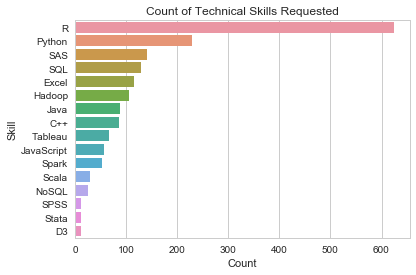

In [10]:
plot_skills()

With some additional tuning, this could search for most frequent bi-grams, tri-grams, or other terms relevant to the job or search of interest. 